# Прогнозирование BPV для производителя еды
## Клиент 1 - Рис длиннозерный 486 гр. Понедельные прогнозы

## Импорты и зависимости

In [ ]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install sktime[all_extras]
!pip install orbit-ml
!pip install prophet
!pip install catboost
!wget https://*** -O utils.py

clear_output()
print("✅ Packages installed.\n⚠️ Be sure to restart the runtime after the first execution of this cell")

✅ Packages installed.
⚠️ Be sure to restart the runtime after the first execution of this cell


In [ ]:
%matplotlib inline

# presentation
from typing import Tuple
from IPython import display
from orbit.diagnostics.plot import plot_predicted_data
import matplotlib.pyplot as plt

# service
from sklearn.metrics import mean_absolute_error
import itertools
import pandas as pd
import numpy as np

# models
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

from orbit.models.lgt import LGT
from orbit.models.dlt import DLT
from orbit.models.ktrlite import KTRLite
from prophet import Prophet

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

# utils
import utils

## Чтение и обработка данных

In [ ]:
train_sales, test_sales, train_promo, test_promo = utils.get_all_data()

⬇️ Loading data...
🔄 Unzipping data...
🧹 Cleaning up...
📜 Creating DataFrames & filling zeros...
✅ Completed.


In [ ]:
repo = utils.Repo(train_sales)
test_repo = utils.Repo(test_sales)
train_promo_repo = utils.Repo(train_promo)
test_promo_repo = utils.Repo(test_promo)

### BPV & Total Sell-in

Т.к. произошла замена DFU с 'Рис длиннозерный 500 гр', на 'Рис длиннозерный 486 гр' по экономическим причинам (а по факту это один и тот же товар), то будем использовать данные первого DFU для прогнозов по второму. Для этого соединим данные продаж по этим двум позициям.

In [1]:
sales_500 = repo.get_data(1, 'Рис длиннозерный 500 гр', date_from='2018-05-07', date_to='2021-03-28')
sales_500

In [2]:
sales_486 = repo.get_data(1, 'Рис длиннозерный 486 гр', date_from='2021-03-29')
sales_486

In [3]:
sales_rice_merged = sales_500.append(sales_486)
sales_rice_merged

In [4]:
sales_rice_test = test_repo.get_data(1, 'Рис длиннозерный 486 гр')
sales_rice_test.head(5)

### Promo

In [5]:
train_promo_rice500 = train_promo_repo.get_data(1, 'Рис длиннозерный 500 гр')
train_promo_rice500 = train_promo_rice500[train_promo_rice500['End Date of shipment'] <= '2021-03-28']
train_promo_rice500.head(5)

In [6]:
train_promo_rice486 = train_promo_repo.get_data(1, 'Рис длиннозерный 486 гр')
train_promo_rice486 = train_promo_rice486[train_promo_rice486['First Date of shipment'] >= '2021-03-29']
train_promo_rice486.head(5)

In [7]:
train_promo_rice = train_promo_rice500.append(train_promo_rice486)
train_promo_rice.head(5)

In [8]:
test_promo_rice = test_promo_repo.get_data(1, 'Рис длиннозерный 486 гр')
test_promo_rice.head(5)

## Генерация признака

In [9]:
data = utils.generate_feature(sales_rice_merged, train_promo_rice)\
    .set_index('Period')\
    .reset_index()
data

In [10]:
test_data = utils.generate_feature(sales_rice_test, test_promo_rice)\
    .set_index('Period')\
    .reset_index()
test_data.head(5)

## Разбиение на train/validation

Примечание: валидационные выборки в данном ноутбуке будут иметь постфиксы `_test`. Реальные тестовые данные будут иметь постфикс `_real_test`.

In [ ]:
def split_train_test(data: pd.DataFrame, train_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    border = int(len(data) * train_size)
    train, test = data.loc[:border-1], data.loc[border:]
    
    assert len(train) + len(test) == len(data), "❌ total length of parts must be equal to the length of given dataset"
    return train, test


def split_df_x_y(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    x_cols = [col for col in ['Period', 'Promo_period', 'SOD_percentage'] if col in data.columns]
    y_cols = 'BPV'

    return (data[x_cols],  # X
            data[y_cols])  # y

def split_x_y(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.Series, pd.Series,
                                                                pd.Series, pd.Series]:
    x_cols = [col for col in ['Period', 'Promo_period'] if col in train.columns]
    y_cols = 'BPV'

    return (train[x_cols], test[x_cols],  # X
            train[y_cols], test[y_cols])  # y


def split_dataset(ts: pd.DataFrame, train_size: float) -> Tuple[pd.Series, pd.Series,
                                                                pd.Series, pd.Series]:
    df = ts.reset_index()                                                              
    train, test = split_train_test(df, train_size=train_size)

    return split_x_y(train, test)


In [ ]:
train_size = 0.9

In [ ]:
df_train, df_test = split_train_test(data, train_size=train_size)

In [ ]:
X_train, X_test, y_train, y_test = split_x_y(df_train, df_test)

In [ ]:
X_total_train, y_total_train = split_df_x_y(data=data)
X_real_test, y_real_test = split_df_x_y(data=test_data)

## Добавление дополнительных признаков

In [ ]:
X_train = utils.make_date_features(X_train)
X_test = utils.make_date_features(X_test)

X_total_train = utils.make_date_features(X_total_train)
X_real_test = utils.make_date_features(X_real_test)

In [ ]:
assert len(X_train) == len(y_train), f'❌ X_train length ({len(X_train)}) is not equal to y_train length ({len(y_train)})'
assert len(X_test) == len(y_test), f'❌ X_test length ({len(X_test)}) is not equal to y_test length ({len(y_test)})'

assert len(X_total_train) == len(y_total_train), f'❌ X_train length ({len(X_total_train)}) is not equal to y_train length ({len(y_total_train)})'
assert len(X_real_test) == len(y_real_test), f'❌ X_test length ({len(X_real_test)}) is not equal to y_test length ({len(y_real_test)})'

## Анализ временных рядов

* Отрисуем временные ряды с очисткой и без нее и визуально сделаем различимым разбиение на train и val выборки.

* Построим графики автокорреляционных функций для временных рядов.

* Попробуем построить графики сезонности (если она присутствует), для чего разобьем временной ряд на повторяющиеся фрагменты и нарисуем их наложенными для иллюстрации этой сезонности.

In [ ]:
def plot_data(train, test):
  plt.figure(figsize=(12, 4))
  plt.plot(train['Period'], train['BPV'], c='blue', label='Train')
  plt.plot(test['Period'], test['BPV'], c='red', label='Test')
  plt.ylabel('BPV')
  plt.xlabel('Time')
  plt.legend()
  plt.title(test['DFU'].values[-1] + ' - BPV')
  plt.show()

График без очистки выбросов

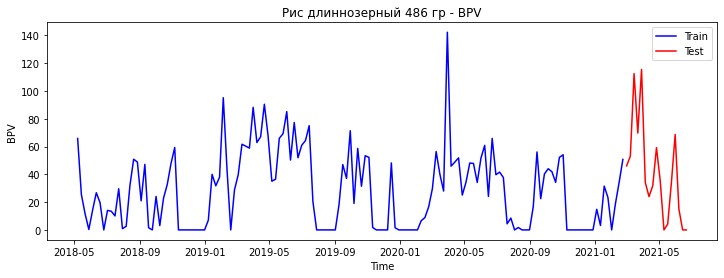

In [ ]:
plot_data(*split_train_test(data, train_size=train_size))

График с очисткой выбросов

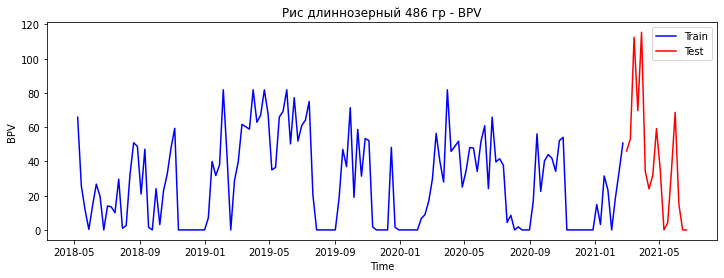

In [ ]:
plot_data(utils.clean_data(df_train), df_test)

**График с реальными тестовыми данными**

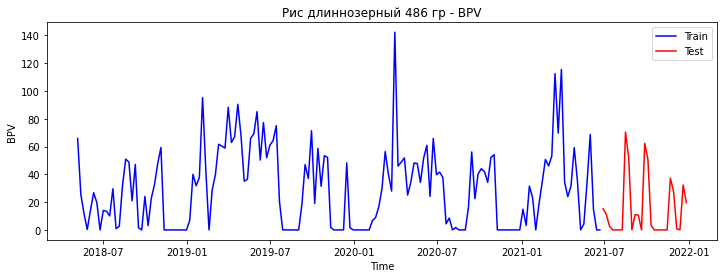

In [ ]:
plot_data(data, test_data)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
def show_acf_pacf_plot(data, lags):
    fig, ax = plt.subplots(2, figsize=(19,8))
    ax[0] = plot_acf(data, ax=ax[0], lags=lags)
    ax[1] = plot_pacf(data, ax=ax[1], lags=lags)

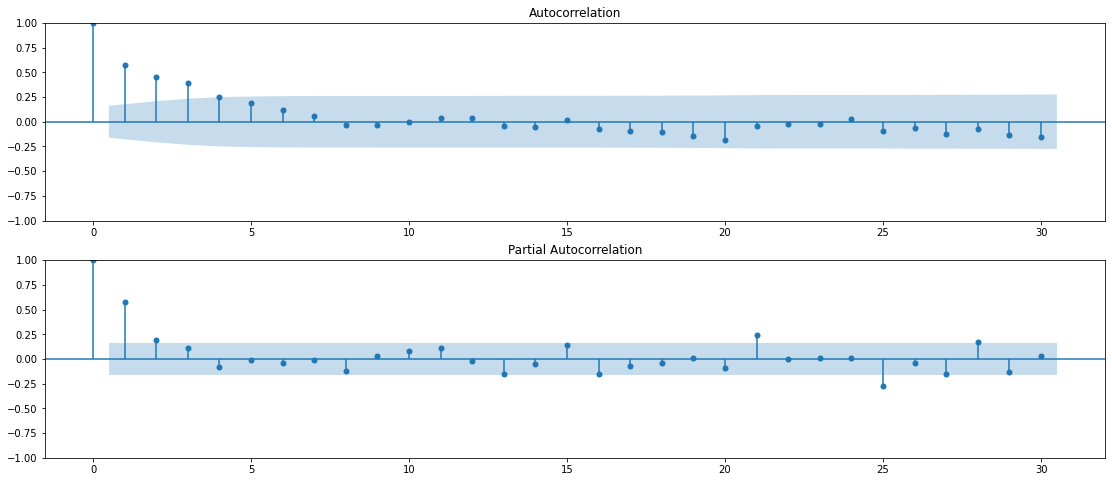

In [ ]:
show_acf_pacf_plot(y_train, lags=30)

In [ ]:
def plot_periods(X_train, y_train, period_days, title):
    n = X_train.shape[0] // period_days
    colors = [plt.cm.Set2(i) for i in range(n)] 
    plt.figure(figsize=(16, 12))

    first = int(str(X_train.values[0])[:4])
    for i in range(n):
        plt.plot(X_train[:period_days], y_train[period_days * i: period_days * (i+1)], label=f"{first+i}")

    plt.title(title)
    plt.ylabel('Value')
    plt.xlabel('Date')

    plt.legend(loc='upper right')
    plt.show()

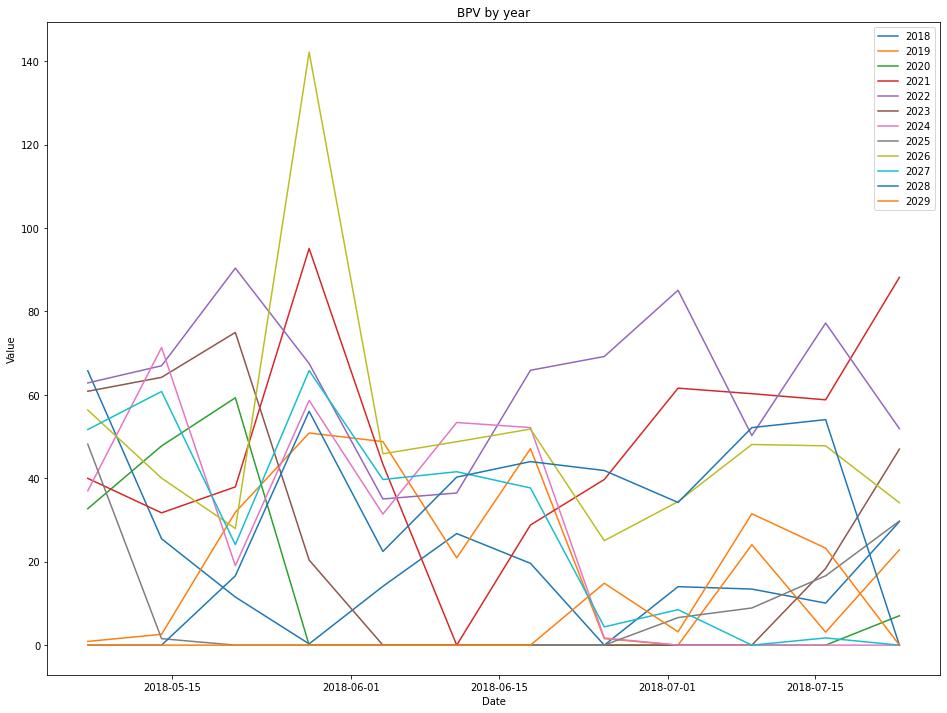

In [ ]:
plot_periods(X_train['Period'], y_train, 12, 'BPV by year')

## Предсказание временного ряда различными моделями 

### NaiveForecaster из sktime 

Предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

#### Тренировка

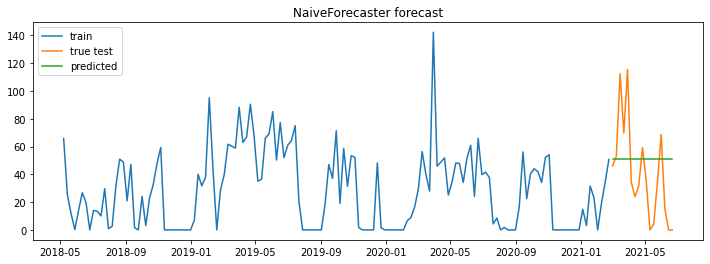


📝 Test quality : 27.827503834356616


In [ ]:
naive_res = utils.forecast_simple(
    NaiveForecaster(strategy='last'),
    y_train,
    y_test,
    X_test,
    X_train
)

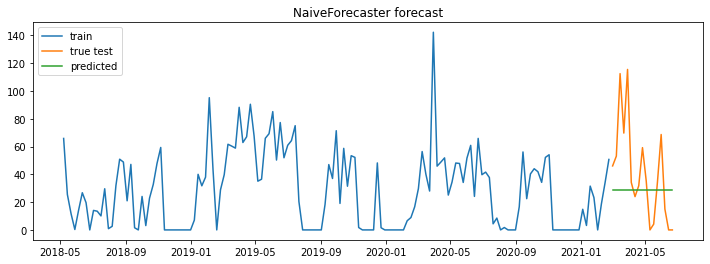


📝 Test quality : 32.46198793517772


In [ ]:
naive_mean = utils.forecast_simple(
    NaiveForecaster(strategy='mean'),
    y_train,
    y_test,
    X_test,
    X_train
)

In [ ]:
qual_arr = [np.nan]
for sp in range(1, 101):
    naive_sp_forecast = utils.forecast_simple(
        NaiveForecaster(sp=sp),
        y_train,
        y_test,
        X_test,
        X_train,
        show_plot=False
    )
    qual = utils.quality(*naive_sp_forecast)
    qual_arr.append(qual)

clear_output()
qual_arr = np.array(qual_arr)
best_sp = np.nanargmax(qual_arr)
best_sp

47

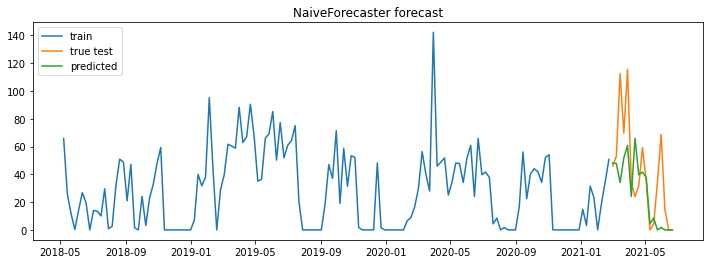


📝 Test quality : 48.367395619495525


In [ ]:
naive_sp47 = utils.forecast_simple(
    NaiveForecaster(sp=47),
    y_train,
    y_test,
    X_test,
    X_train
)

#### Прогноз на тестовых данных

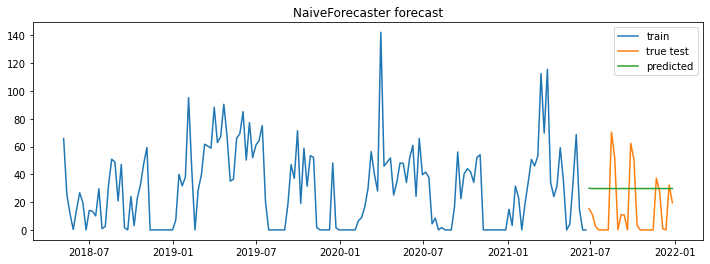


📝 Test quality : -59.51181468033884


In [ ]:
naive_mean_test = utils.forecast_simple(
    NaiveForecaster(strategy='mean'),
    y_train=y_total_train,
    y_test=y_real_test,
    X_train=X_total_train,
    X_test=X_real_test
)

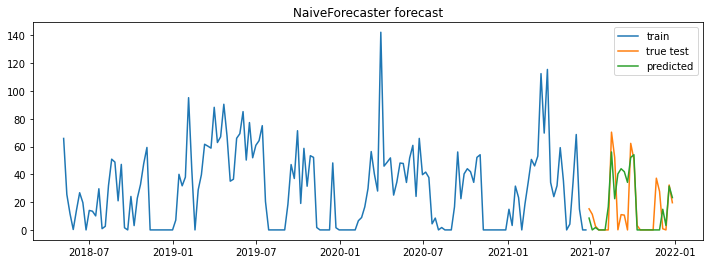


📝 Test quality : 21.069759723858116


In [ ]:
naive_sp47_test = utils.forecast_simple(
    NaiveForecaster(sp=47),
    y_train=y_total_train,
    y_test=y_real_test,
    X_train=X_total_train,
    X_test=X_real_test
)

In [ ]:
utils.save_results(
    *naive_sp47_test,
    comment='TEST-WEEKLY-1-Рис длиннозерный 486-naive'
)

### ARIMA/AutoArima 

модели из библиотеки `sktime` :

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

#### Тренировка

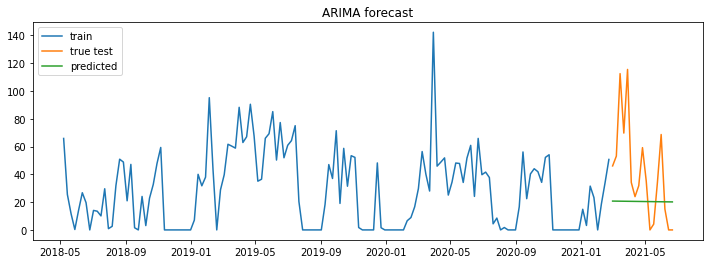


📝 Test quality : 26.074606671127796


In [ ]:
arima_res = utils.forecast_simple(
    ARIMA(
        order=(1, 1, 1), 
        seasonal_order=(1, 0, 0, 12)
    ),
    y_train,
    y_test,
    X_test,
    X_train
)

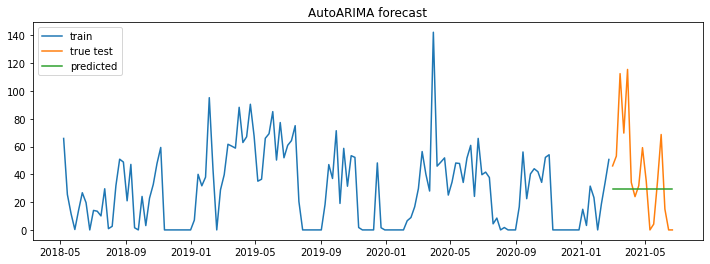


📝 Test quality : 33.01546753163757


In [ ]:
auto_arima_res = utils.forecast_simple(
    AutoARIMA(),
    y_train,
    y_test,
    X_test,
    X_train
)

#### Прогноз на тестовых данных

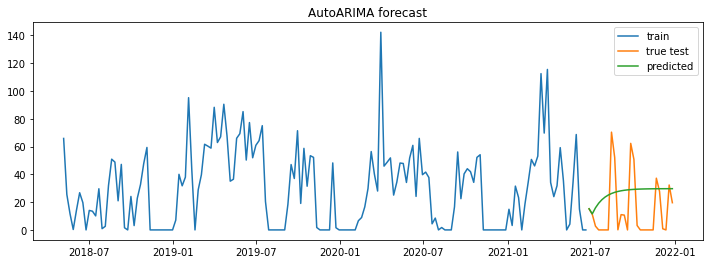


📝 Test quality : -40.74529135103144


In [ ]:
auto_arima_res_test = utils.forecast_simple(
    AutoARIMA(),
    y_train=y_total_train,
    y_test=y_real_test,
    X_test=X_real_test,
    X_train=X_total_train
)

### LGT/DLT 

модели LGT и DLT из библиотеки `orbit` 

In [ ]:
def plot_orbit(df_train, df_test, df_pred, title):
    _ = plot_predicted_data(
        training_actual_df=df_train, 
        predicted_df=df_pred,
        date_col=forecaster.date_col, 
        actual_col=forecaster.response_col,
        test_actual_df=df_test, 
        title=title
    )

def forecast_orbit(forecaster, df_train, df_test, model_name=None) -> pd.DataFrame:
    forecaster.fit(df=df_train)
    df_pred = forecaster.predict(df_test)
    
    model = f'{model_name} Model' if model_name is not None else ''
    plot_orbit(df_train, df_test, df_pred, title=f'{model} ({type(forecaster).__name__} forecaster) forecast')

    wape_quality = utils.quality(
        df_test['BPV'].values,
        df_pred['prediction'].values
    )
    print(f"\n📝 Quality (1 - WAPE): {wape_quality * 100}")

    return df_pred

#### Тренировка

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


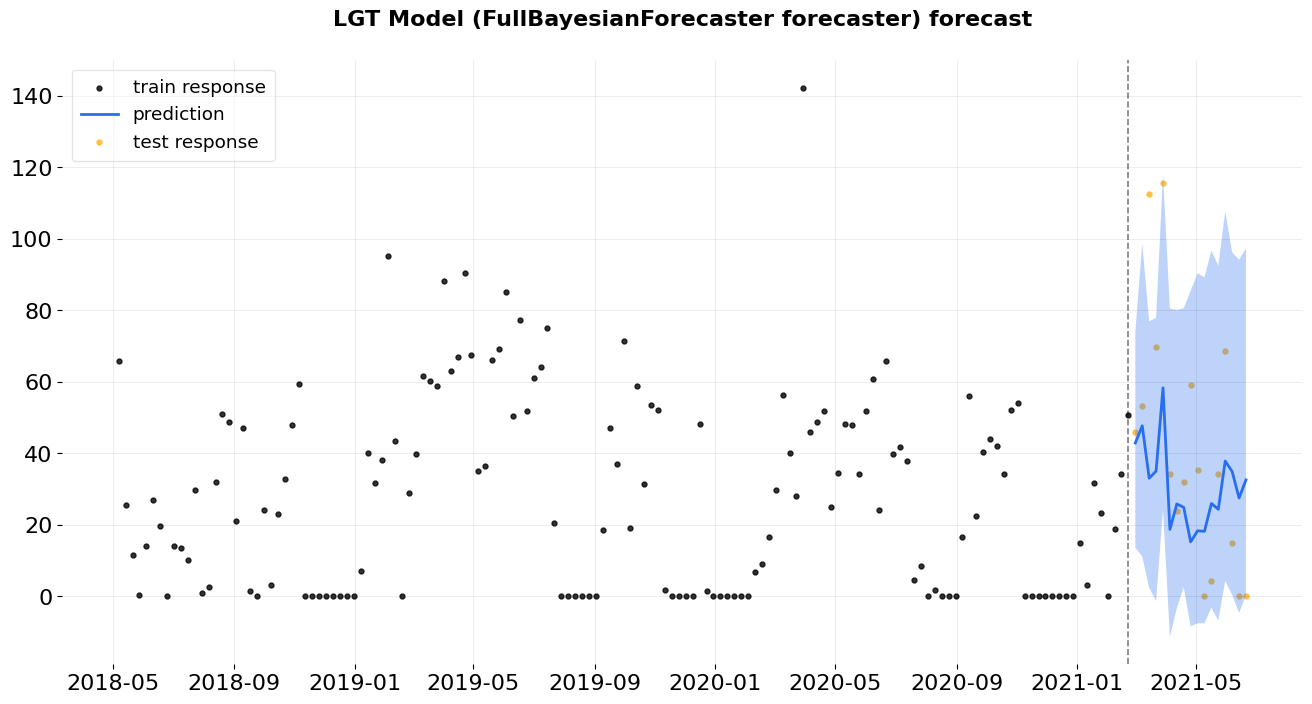


📝 Test WAPE quality: 39.42787543216144


In [ ]:
forecaster = LGT(
    response_col='BPV',
    date_col='Period',
    seasonality=52,
    seed=139
)

lgt_pred = forecast_orbit(
    forecaster,
    df_train,
    df_test,
    model_name="LGT"
)

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


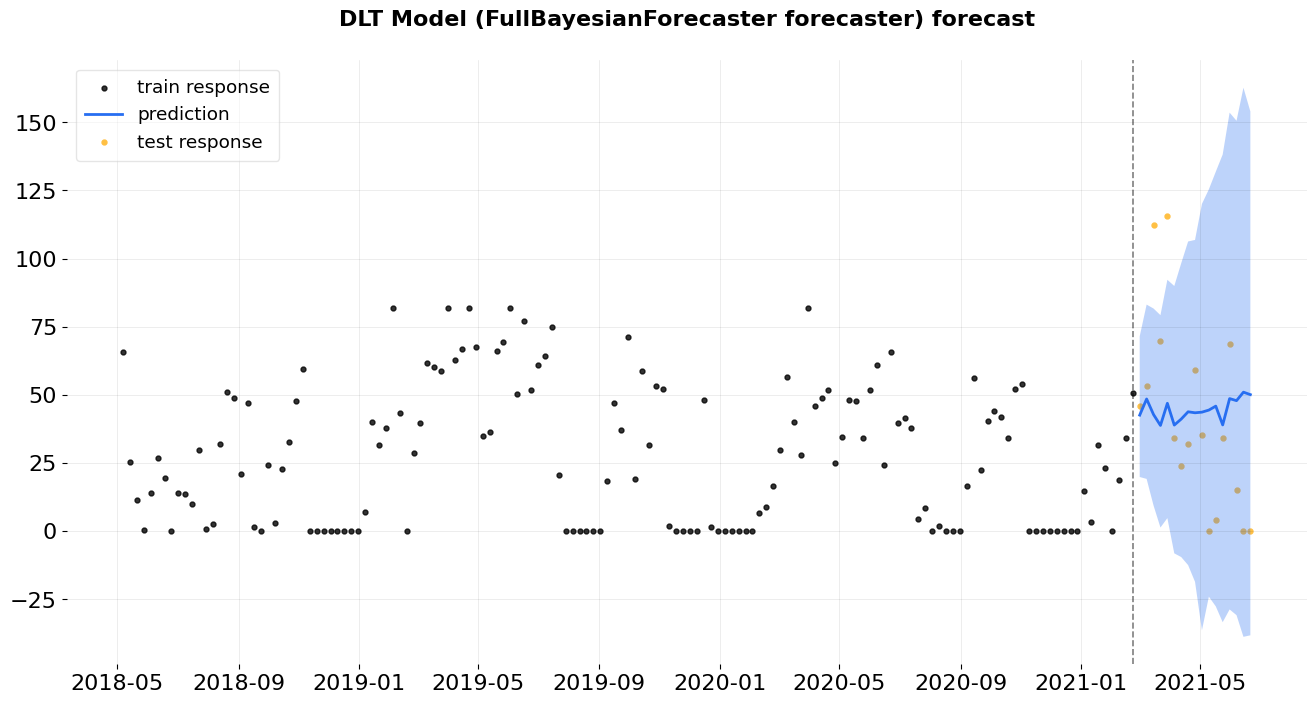


📝 Test WAPE quality: 31.715427609862722


In [ ]:
forecaster = DLT(
    response_col='BPV',
    date_col='Period',
    seasonality=52,
    seed=139
)

dlt_pred = forecast_orbit(
    forecaster,
    df_train,
    df_test,
    model_name="DLT"
)

#### Прогноз на тестовых данных

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


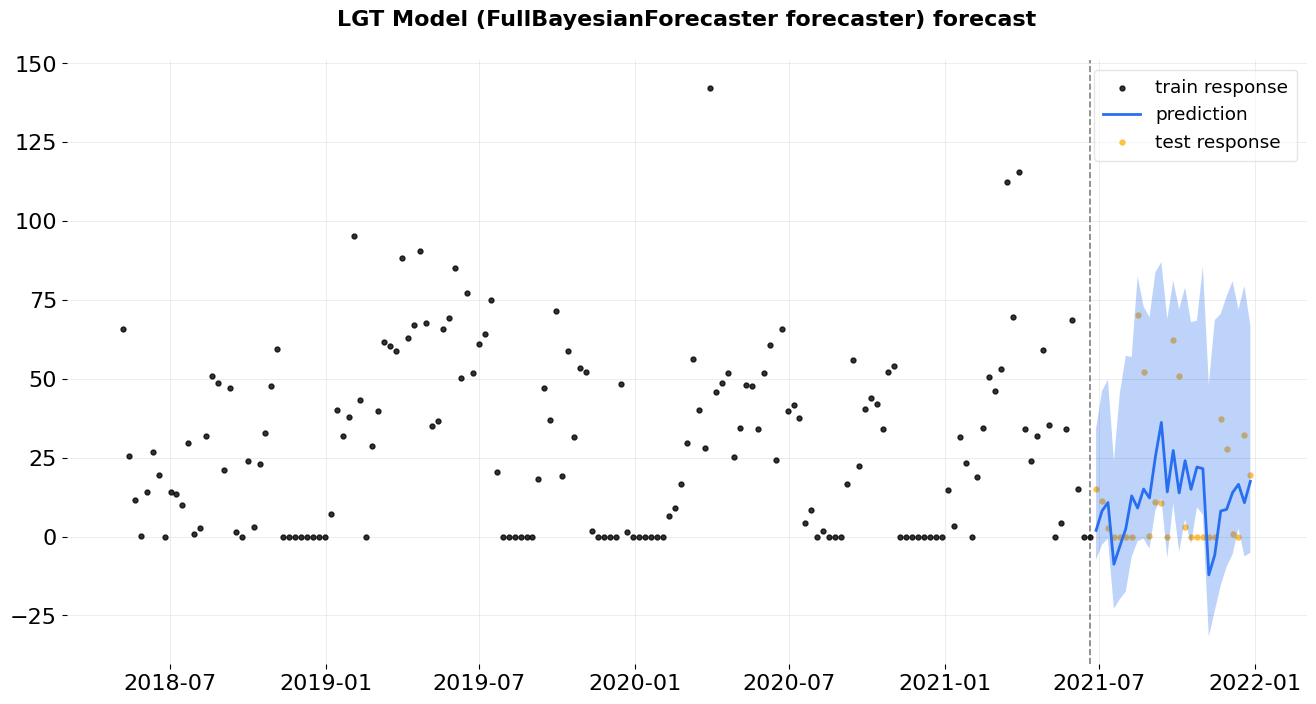


📝 Test WAPE quality: -19.603192839197447


In [ ]:
forecaster = LGT(
    response_col='BPV',
    date_col='Period',
    seasonality=52,
    seed=139
)

lgt_pred = forecast_orbit(
    forecaster,
    data,
    test_data,
    model_name="LGT"
)

### ETS

модели из библиотеки `sktime` :

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

#### Тренировка

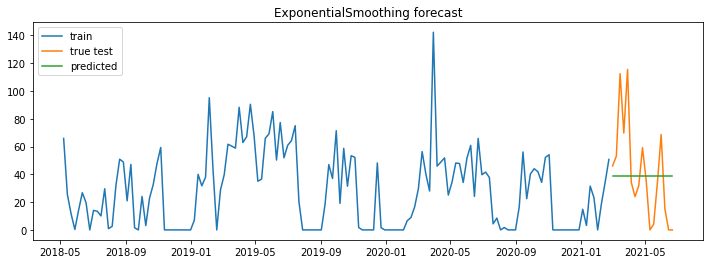


📝 Test quality : 34.329402659124916


In [ ]:
ets_res = utils.forecast_simple(
    ExponentialSmoothing(sp=50),
    y_train,
    y_test,
    X_test,
    X_train
)

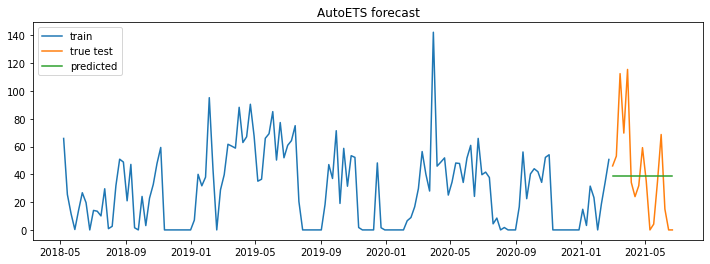


📝 Test quality : 34.32931927477208


In [ ]:
auto_ets_res = utils.forecast_simple(
    AutoETS(trend="add", auto=True, sp=12),
    y_train,
    y_test,
    X_test,
    X_train
)

#### Прогноз на тестовых данных

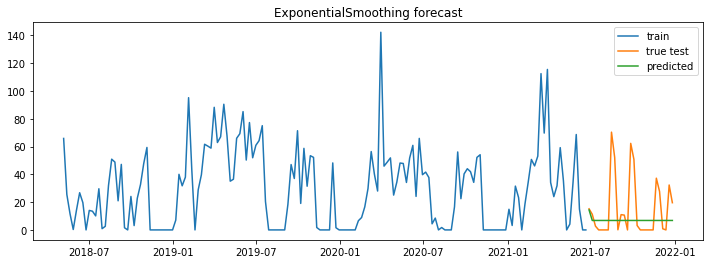


📝 Test quality : 0.18340322306318324


In [ ]:
ets_res_test = utils.forecast_simple(
    ExponentialSmoothing(sp=12),
    y_train=y_total_train,
    y_test=y_real_test,
    X_test=X_real_test,
    X_train=X_total_train
)

### KTR из orbit



INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6ea95f5d2ae85eb1bcb07ba2b0042aff NOW.


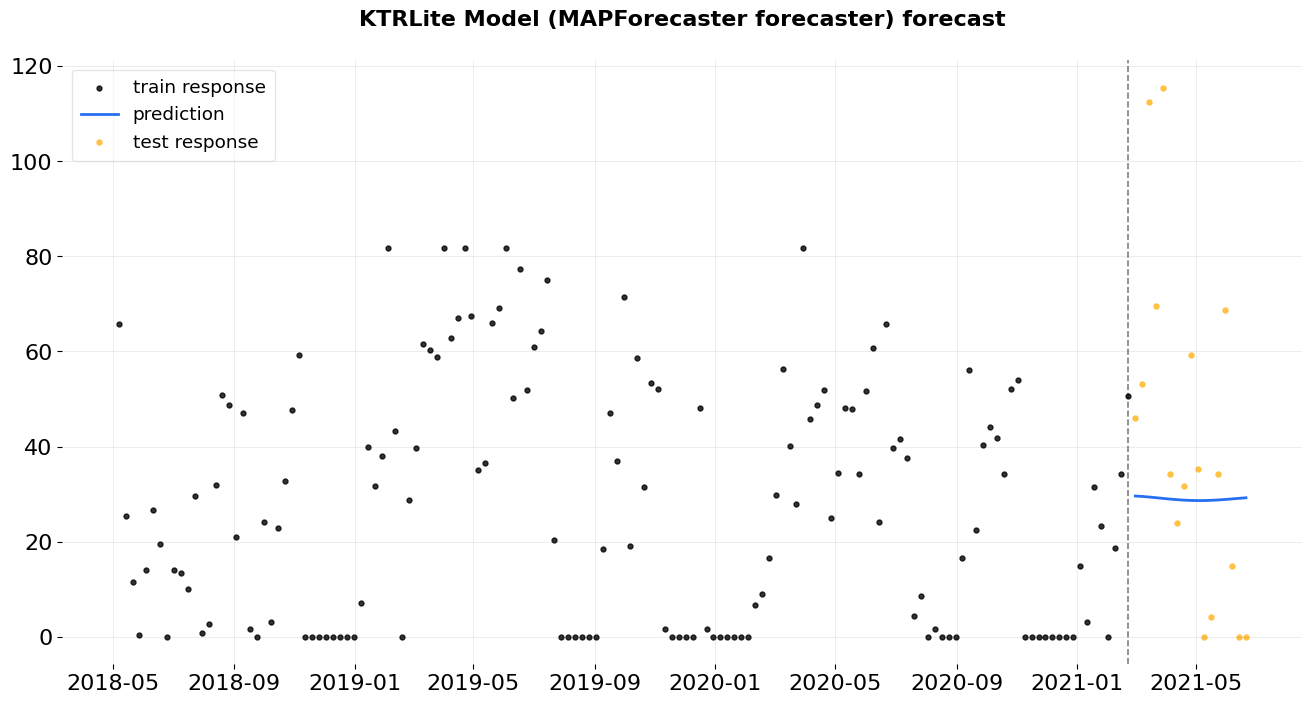


📝 Test WAPE quality: 33.02326223263884


In [ ]:
forecaster = KTRLite(
    response_col='BPV',
    date_col='Period',
    seasonality=52
)

ktr_pred = forecast_orbit(
    forecaster,
    df_train,
    df_test,
    model_name='KTRLite'
)

### Phophet 



In [ ]:
df2_train = df_train.rename(columns={'Period': 'ds', 'BPV': 'y'})
df2_test = df_test.rename(columns={'Period': 'ds', 'BPV': 'y'})

In [ ]:
forecaster = Prophet()
forecaster.fit(df2_train)

future = forecaster.make_future_dataframe(periods=len(df2_test))
prophet_pred = forecaster.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
ypred_prophet = prophet_pred.iloc[-len(df_test):]['yhat']

df_pred_prophet = prophet_pred.rename(columns={
    'yhat': 'prediction', 
    'yhat_lower': 'prediction_5', 
    'yhat_upper': 'prediction_95'
})

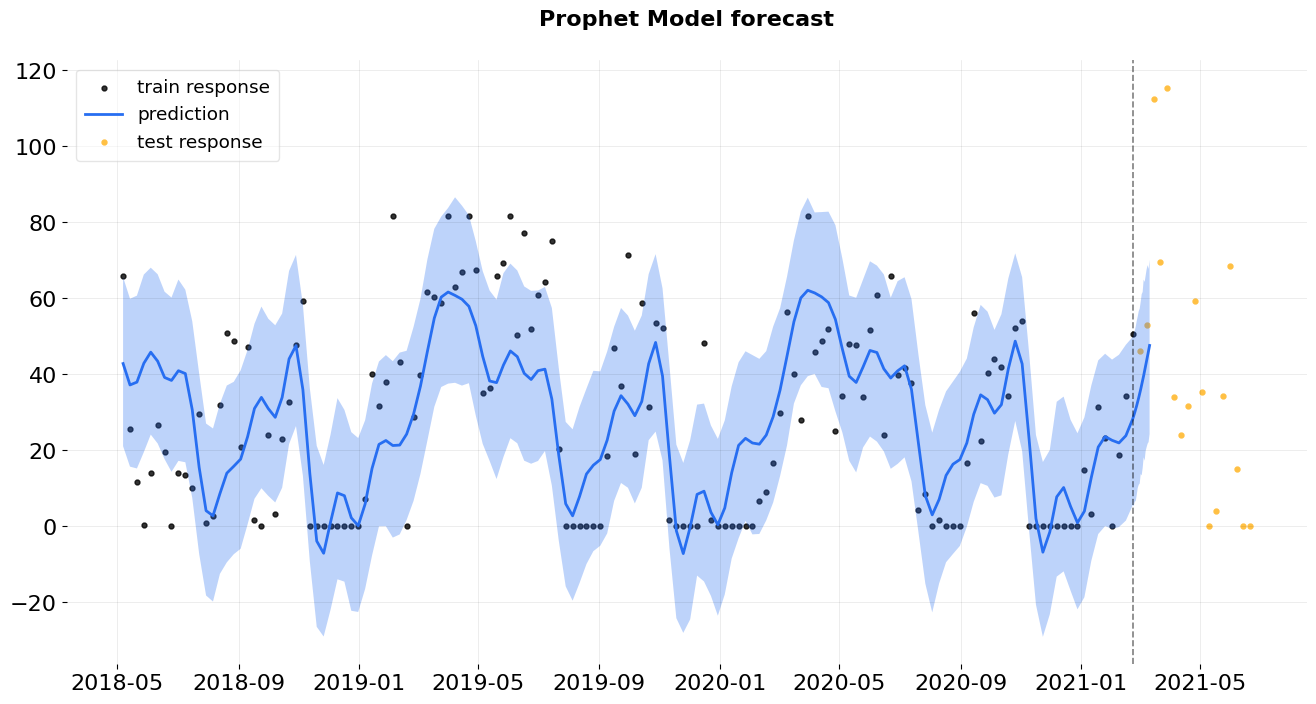

In [ ]:
_ = plot_predicted_data(
        training_actual_df=df2_train, 
        predicted_df=df_pred_prophet,
        date_col='ds', 
        actual_col='y',
        test_actual_df=df2_test, 
        title="Prophet Model forecast"
)

In [ ]:
print(f"\n📝 Test quality: {utils.quality(df_test['BPV'].values, ypred_prophet.values) * 100}")


📝 Test WAPE quality: 26.59233774449782


## Предсказание временного ряда моделями машинного обучения 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def plot_ml_res(y_train, X_train, y_test, X_test, y_pred, title=''):
      period_test = X_test['Period']
      period_train = X_train['Period']

      plt.figure(figsize=(12,4))
      plt.plot(period_train, y_train, label='train')
      plt.plot(period_test, y_test, label='true test')
      plt.plot(period_test, y_pred, label='predicted')

      plt.legend()
      plt.title(f'{title} forecast')
      plt.show()

      print(f"\n📝 Test WAPE quality: {utils.quality(y_test, y_pred) * 100}")

### SVR

#### Тренировка

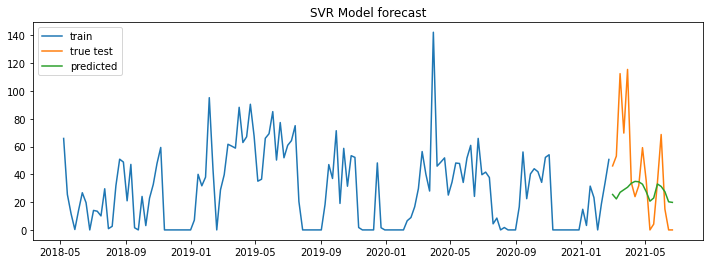


📝 Test WAPE quality: 37.22180441342445


In [ ]:
svr_res = utils.forecast_ml(
    SVR(kernel='rbf'),
    y_train,
    X_train,
    y_test,
    X_test
)

#### Прогноз на тестовых данных

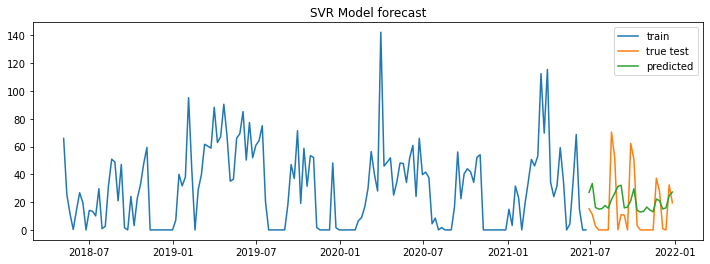


📝 Test WAPE quality: -15.344108732984708


In [ ]:
svr_res_test = utils.forecast_ml(
    SVR(kernel='rbf'),
    y_train=y_total_train,
    X_train=X_total_train,
    y_test=y_real_test,
    X_test=X_real_test
)

### RandomForestRegressor

#### Тренировка

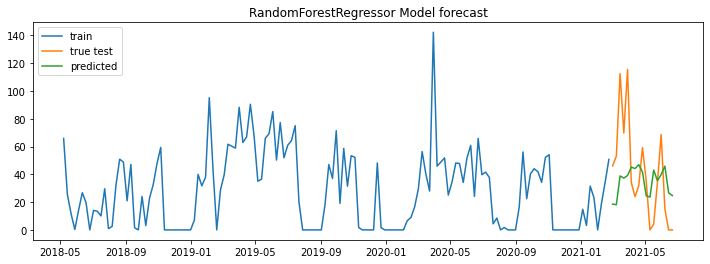


📝 Test WAPE quality: 29.680692456420743


In [ ]:
forest_res = utils.forecast_ml(
    RandomForestRegressor(
        n_estimators=60, 
        criterion='absolute_error',
        random_state=0
    ),
    y_train,
    X_train,
    y_test,
    X_test
)

#### Прогноз на тестовых данных

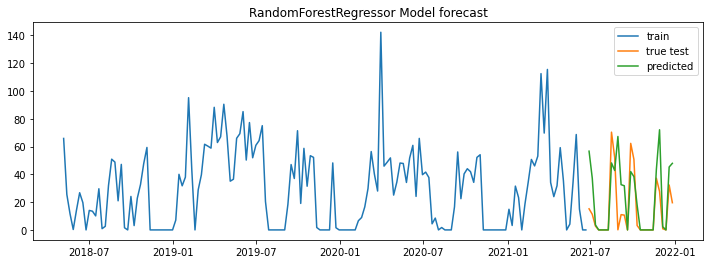


📝 Test WAPE quality: 13.993261694229897


In [ ]:
forest_res_test = utils.forecast_ml(
    RandomForestRegressor(
        n_estimators=640, 
        criterion='absolute_error',
        random_state=0
    ),
    y_train=y_total_train,
    X_train=X_total_train,
    y_test=y_real_test,
    X_test=X_real_test
)

### GradientBoostingRegressor

#### Тренировка

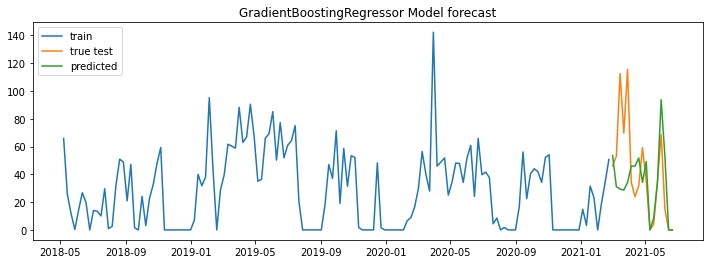


📝 Test WAPE quality: 43.83205720215796


In [ ]:
grboost_res_test = utils.forecast_ml(
    GradientBoostingRegressor(
        random_state=42, 
        n_estimators=1500, 
        max_depth=12
    ),
    y_train,
    X_train,
    y_test,
    X_test
)

#### Прогноз на тестовых данных

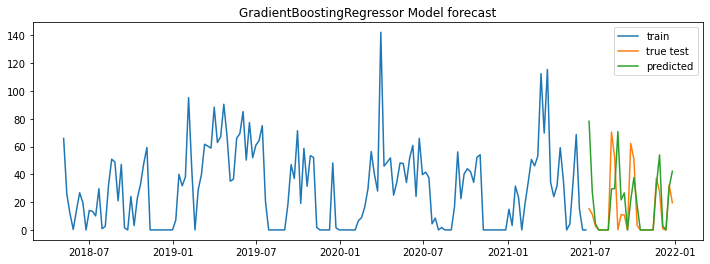


📝 Test WAPE quality: 9.557070572341352


In [ ]:
grboost_res_test = utils.forecast_ml(
    GradientBoostingRegressor(
        random_state=42, 
        n_estimators=1500, 
        max_depth=12
    ),
    y_train=y_total_train,
    X_train=X_total_train,
    y_test=y_real_test,
    X_test=X_real_test
)

### Catboost

#### Тренировка

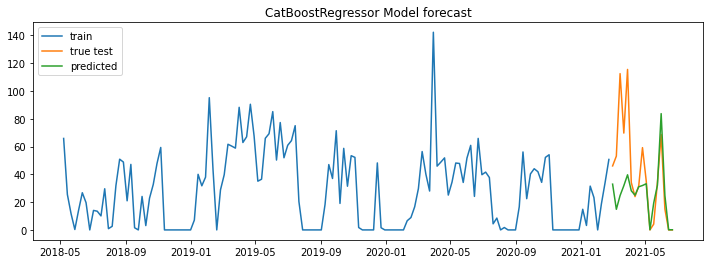


📝 Test WAPE quality: 52.74342196414271


In [ ]:
catboost_pred = utils.forecast_ml(
    CatBoostRegressor(loss_function='MAPE', verbose=False),
    y_train,
    X_train,
    y_test,
    X_test
)

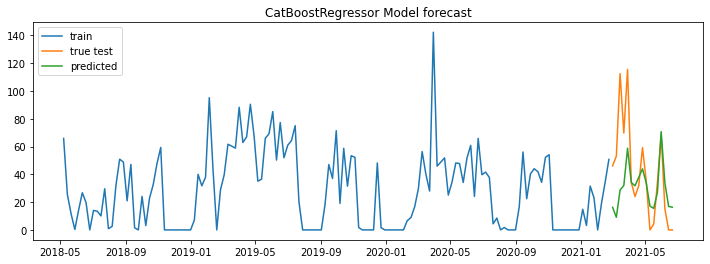


📝 Test WAPE quality: 47.04811479757572


In [ ]:
catboost_pred = utils.forecast_ml(
    CatBoostRegressor(loss_function='MAPE', verbose=False),
    y_train,
    X_train,
    y_test,
    X_test
)

#### Прогноз на тестовых данных

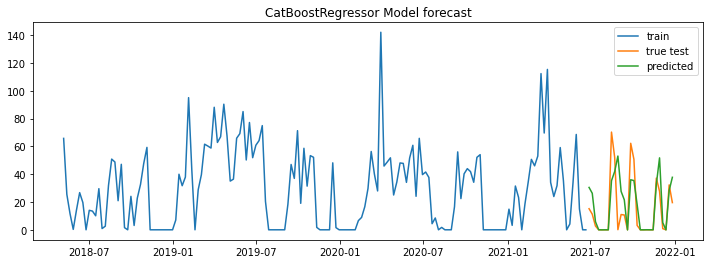


📝 Test WAPE quality: 33.3785136668111


In [ ]:
catboost_res_test = utils.forecast_ml(
    CatBoostRegressor(loss_function='MAPE', verbose=False),
    y_train=y_total_train,
    X_train=X_total_train,
    y_test=y_real_test,
    X_test=X_real_test
)

In [ ]:
utils.save_results(
    y_real_test,
    catboost_res_test,
    comment='TEST-WEEKLY-1-Рис длиннозерный 486-catboost'
)

In [ ]:
utils.save_results(
    y_test,
    catboost_pred,
    comment='VAL-WEEKLY-1-Рис длиннозерный 486-catboost'
)

## Предсказание временного ряда нейросетями

In [ ]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random

In [ ]:
def set_random_seed(seed=37844):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
def plot_history(train_history, val_history, title="Loss"):
    plt.figure(figsize=(12,4))
    #plt.ylim(6, 17)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.grid()

    plt.plot(train_history, '--r', marker='o', c='blue', label="train", zorder=1)
    plt.plot(val_history, '--r', marker='o', c="red", label="test", zorder=2)

    plt.legend()
    plt.show()


In [ ]:
ss = StandardScaler()

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [ ]:
# Datasets 
train_dataset = MyDataset(
    torch.from_numpy(ss.fit_transform(X_train.drop(columns=['Period']))).float(),
    torch.from_numpy(y_train.values).float(),
)
val_dataset = MyDataset(
    torch.from_numpy(ss.transform(X_test.drop(columns=['Period']))).float(),
    torch.from_numpy(y_test.values).float(),
)

# Data Loaders 
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=5,
    shuffle=True,
    num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=len(y_test),
    shuffle=False,
    num_workers=1
)

In [ ]:
def train(model, optimizer, criterion, train_loader, device):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''

    model = model.to(device).train()
    losses = []

    for X_batch, y_batch in train_loader:
        # Move Batch to device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        # Calculate 
        y_pred = model(X_batch)
        assert y_pred.shape == y_batch.shape, f"❌ {y_pred.shape} is not equal to {y_batch.shape}"

        loss = criterion(y_pred, y_batch)

        # Update weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach().item())
    
    return losses

def test(model, criterion, test_loader, device):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    model = model.eval()

    with torch.no_grad():
      for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)

    return y_pred.cpu().detach().numpy(), loss.detach().item()


In [ ]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    criterion,
    device
):
    all_train_losses = []
    all_test_losses = []
    for epoch in range(epochs):
        # Train step
        print(f"\n\n⏳ Epoch: {epoch + 1}")
        print("🏋️ Training ...")
        epoch_train_losses = train(
            model=model,
            train_loader=train_data_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device
        )
        mse_train = np.mean(epoch_train_losses)
        all_train_losses.append(mse_train)
        print(f"Train MSE: {mse_train}")

        # Eval step
        print("\n📝 Testing ...")
        predicts, epoch_test_losses = test(
            model=model,
            test_loader=validation_data_loader,
            criterion=criterion,
            device=device
        )
        mse_test = np.mean(epoch_test_losses)
        all_test_losses.append(mse_test)
        print(f"Test MSE: {mse_test}")

        clear_output()
        print(f"""
⏳ Epoch {epoch + 1} results:
🏋️ Train MSE: {mse_train}
📝 Test MSE: {mse_test}
""")
        plot_history(all_train_losses, all_test_losses)

    return all_train_losses, all_test_losses

In [ ]:
set_random_seed()

model = nn.Sequential(
    nn.Linear(X_train.drop(columns=['Period']).shape[1], 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),

    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),

    nn.Linear(128, 32),
    nn.ReLU(),

    nn.Linear(32, 1)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


⏳ Epoch 50 results:
🏋️ Train MSE: 372.60640284220375
📝 Test MSE: 1712.959228515625



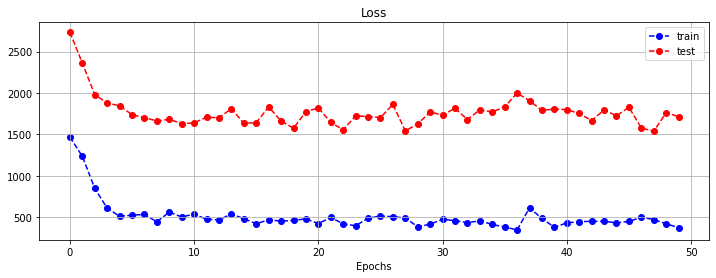

In [ ]:
_, _ = fit(
    model,
    n_epochs,
    train_dataloader,
    val_dataloader,
    optimizer,
    criterion,
    device
)

In [ ]:
test(model, criterion, val_dataloader, device)

(array([[ 6.757777 ],
        [ 5.7021384],
        [24.992521 ],
        [33.32123  ],
        [40.40511  ],
        [32.08557  ],
        [31.185436 ],
        [32.12962  ],
        [33.405346 ],
        [23.05128  ],
        [ 0.6233036],
        [ 5.3003135],
        [12.272525 ],
        [37.022343 ],
        [16.979376 ],
        [ 4.4083986],
        [ 7.5812445]], dtype=float32), 31.94387435913086)

In [ ]:
nn_pred = test(model, criterion, val_dataloader, device)[0]
utils.wape_metric(y_test, nn_pred)

12.91069973821878

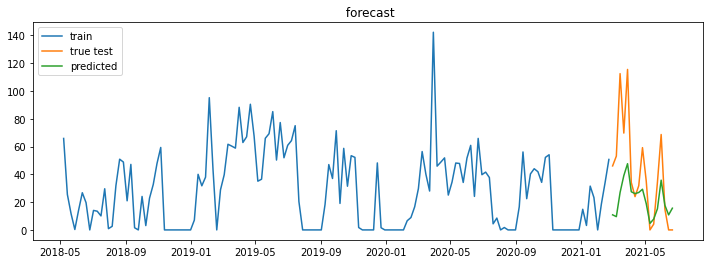


📝 Test WAPE quality: -1191.069973821878


In [ ]:
plot_ml_res(y_train, X_train, y_test, X_test, nn_pred)